# Digit Recognition Task
If this is your first time running a notebook - welcome!! Notebooks are awesome because they let us play around and experiment
with code with near-instant feedback. Some pointers:
1. To execute a cell, click on it and hit SHIFT-Enter
2. Once something is executed, the variables are in memory - inspect them!

## Getting Started
This first cell imports the necessary libraries so we can get started:

In [1]:
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.onnx as onnx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

 ## Data!
 Without data we really can't do anythin with machine learning. At this point we have our sharp question **can we predict a digit given a 28x28 vector of numbers?**
 
 Once that is all squared away we need to take a look at our data. The next cell is a helper function that visualizes the the digits (a sanity check).


In [4]:
def draw_digits(digits):
    fig, axes = plt.subplots(6, 20, figsize=(18, 7),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        X, y = digits[i]
        ax.imshow(255 - X.reshape(28,28) * 255, cmap='gray')
        ax.set_title('{:.0f}'.format(torch.argmax(y).item()))

The next cell downloads the standard digit dataset (called MNIST). The `transform` and `target_transform` parts of this call add some conversion steps to make the data more suitable for the models we will try.

In [5]:
digits = datasets.MNIST('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )

Here is our sanity check!

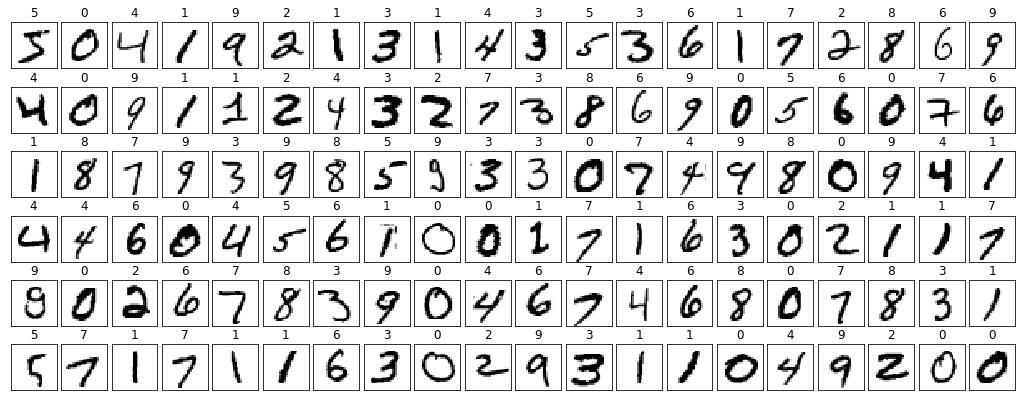

In [6]:
draw_digits(digits)

Feel free to take a look at the data by printing out `x` and/or `y`. They really are just numbers! A couple of things that ight seem strange when you print them out:
1. "I thought you said the images were 784 sized vectors of 0-255???" - They were! We just normalized the vectors by dividing by 255 so the new range is 0-1 (it makes the numbers more tidy)
2. "I thought the `y` was a numerical answer?? Instead it's a 10 sized vector!" - Yes - this is called a one-hot encoding of the answer. Now there's a `1` in the index of the right answer. Again, this makes the math work a lot better for the models we will be creating.

In [7]:
x, y = digits[0]
print(x)
print(y)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

# Choosing Models
Now that we have some data it's time to start picking models we think might work. This is where the science part of data-science comes in: we guess and then check if our assumptions were right. Imagine models like water pipes that have to distribute water to 10 different hoses depending on 784 knobs. These 784 knobs represent the individual pixels in the digit and the 10 hoses at the end represent the actual number (or at least the index of the one with the most water coming out of it). Our job now is to pick the plumbing in between.

The next three cells represent three different constructions in an increasingly more complex order:

1. The first is a simple linear model,
2. The second is a 3 layer Neural Network,
3. and the last is a full convolutional neural network

While it is out of the scope of this tutorial to fully explain how they work, just imagine they are basically plumbing with internal knobs that have to be tuned to produce the right water pressure at the end to push the most water out of the right
index. As you go down each cell the plumbing and corresponding internal knobs just get more complicated.

In [8]:
class Logistic(nn.Module):
    def __init__(self):
        super(Logistic, self).__init__()
        self.layer1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.layer1(x)
        return F.softmax(x, dim=1)

In [9]:
class NeuralNework(nn.Module):
    def __init__(self):
        super(NeuralNework, self).__init__()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.output = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Optimizing Model Parameters
Now that we have some models it's time to optimize the internal parameters to see if it can do a good job at recognizing digits! It turns out there are some parameters that we can give the optimization algorithm to tune how it trains - these are called hyper-parameters. That's what the two variables represent below:

In [9]:
learning_rate = 1e-3
epochs = 5

In [11]:
# where to run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# selected model
model = Logistic().to(device)
print(model)

# cost function used to determine best parameters
cost = torch.nn.BCELoss()

# used to create optimal parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loader
dataloader = DataLoader(digits, batch_size=64, num_workers=0, pin_memory=True)

Using cuda device
Logistic(
  (layer1): Linear(in_features=784, out_features=10, bias=True)
)


In [12]:
for t in range(epochs):
    print('Epoch {}'.format(t))
    print('-------------------------------')
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print('loss: {:>10f}  [{:>5d}/{:>5d}]'.format(loss.item(), batch * len(X), len(dataloader.dataset)))
            
    print('loss: {:>10f}  [{:>5d}/{:>5d}]\n'.format(loss.item(), len(dataloader.dataset), len(dataloader.dataset)))
    
print('Done!')

Epoch 0
-------------------------------
loss:   0.325457  [    0/60000]
loss:   0.119222  [ 6400/60000]
loss:   0.093703  [12800/60000]
loss:   0.082313  [19200/60000]
loss:   0.063306  [25600/60000]
loss:   0.072841  [32000/60000]
loss:   0.050686  [38400/60000]
loss:   0.082538  [44800/60000]
loss:   0.065879  [51200/60000]
loss:   0.074062  [57600/60000]
loss:   0.027727  [60000/60000]

Epoch 1
-------------------------------
loss:   0.051775  [    0/60000]
loss:   0.052172  [ 6400/60000]
loss:   0.045386  [12800/60000]
loss:   0.063412  [19200/60000]
loss:   0.041841  [25600/60000]
loss:   0.064805  [32000/60000]
loss:   0.035988  [38400/60000]
loss:   0.073465  [44800/60000]
loss:   0.055540  [51200/60000]
loss:   0.074185  [57600/60000]
loss:   0.019937  [60000/60000]

Epoch 2
-------------------------------
loss:   0.038884  [    0/60000]
loss:   0.048036  [ 6400/60000]
loss:   0.036920  [12800/60000]
loss:   0.056741  [19200/60000]
loss:   0.038440  [25600/60000]
loss:   0.0620

In [13]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.0101,  0.0073, -0.0187,  ..., -0.0345,  0.0150,  0.0006],
        [-0.0205, -0.0352,  0.0195,  ..., -0.0206, -0.0265, -0.0049],
        [ 0.0058, -0.0302,  0.0202,  ..., -0.0078,  0.0157,  0.0031],
        ...,
        [-0.0283,  0.0031,  0.0109,  ..., -0.0176, -0.0295, -0.0033],
        [ 0.0141, -0.0043, -0.0152,  ..., -0.0293, -0.0287,  0.0274],
        [ 0.0150, -0.0259, -0.0257,  ..., -0.0348, -0.0026, -0.0343]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.2354,  0.4045,  0.0322, -0.2214,  0.1039,  0.6801, -0.0201,  0.3639,
        -0.7942, -0.1494], device='cuda:0', requires_grad=True)


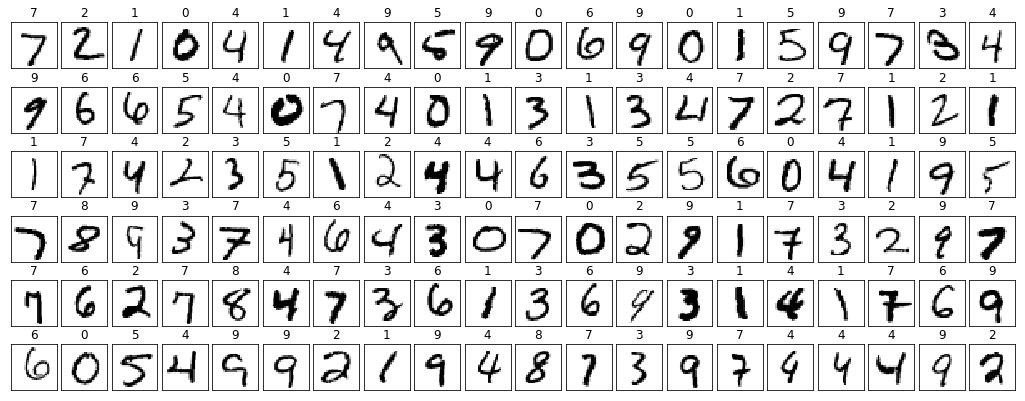

In [14]:
test_digits = datasets.MNIST('data', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )
draw_digits(test_digits)

In [15]:
x, y = test_digits[0]
x = x.to(device).view(1, 28*28)

In [16]:
model.eval()
with torch.no_grad():
    pred = model(x)
    pred = pred.to('cpu').detach()[0]

In [17]:
pred.argmax(0), y.argmax(0)

(tensor(7), tensor(7))

In [18]:
# data loader for test digits
test_dataloader = DataLoader(test_digits, batch_size=64, num_workers=0, pin_memory=True)

# set model to evaluation mode
model.eval()
test_loss = 0
correct = 0

# loop! 
with torch.no_grad():
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        test_loss += cost(pred, Y).item()
        correct += (pred.argmax(1) == Y.argmax(1)).type(torch.float).sum().item()

test_loss /= len(dataloader.dataset)
correct /= len(dataloader.dataset)
print('\nTest Error:')
print('acc: {:>0.1f}%, avg loss: {:>8f}'.format(100*correct, test_loss))


Test Error:
acc: 92.6%, avg loss: 0.000700


In [19]:
# create dummy variable to traverse graph
x = torch.randint(255, (1, 28*28), dtype=torch.float).to(device) / 255
onnx.export(model, x, 'model.onnx')
print('Saved onnx model to model.onnx')

# saving PyTorch Model Dictionary
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch Model to model.pth')

Saved onnx model to model.onnx
Saved PyTorch Model to model.pth
